<a href="https://colab.research.google.com/github/marcosgabrielll/Segmentacao_imagens_de_bacterias/blob/main/Segmenta%C3%A7%C3%A3o_de_Imagens_Bacterias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importação das bibliotecas**

In [ ]:
import cv2 #OpenCV
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from PIL import Image, ImageDraw

In [ ]:
#conexão com o google drive
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Para copiar precisamos pegar do linux (servidor)
!cp -R /content/gdrive/MyDrive/Segmentação_de_Imagens/imagens/ imagens/

# Limiarização

In [ ]:
def mostrar(imagem):
  fig = plt.gcf()
  fig.set_size_inches(18,6)
  plt.imshow(cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB), cmap='gray')
  plt.axis('off')
  plt.show()

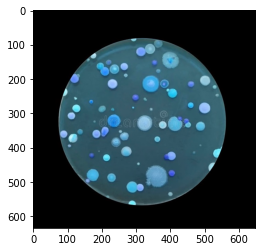

In [ ]:
img= cv2.imread('/content/gdrive/MyDrive/Segmentação_de_Imagens/imagens/COLONIA-2.jpg')
plt.imshow(img);

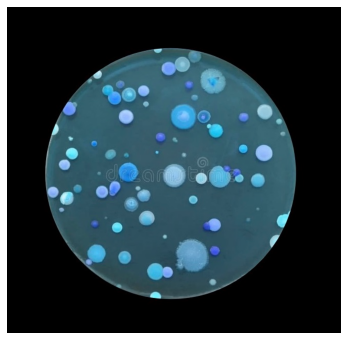

In [ ]:
rgb= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
mostrar(rgb);

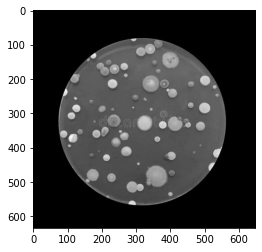

In [ ]:
gray= cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap='gray');

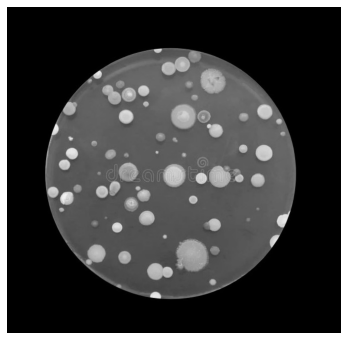

In [ ]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
mostrar(gray)

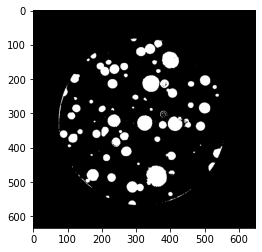

In [ ]:
limiar=  125# @param {type: "slider", min:0, max:255, step:1}
val, thresh= cv2.threshold(gray, limiar, 255, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray');

Binarização- Limiarização

53.0


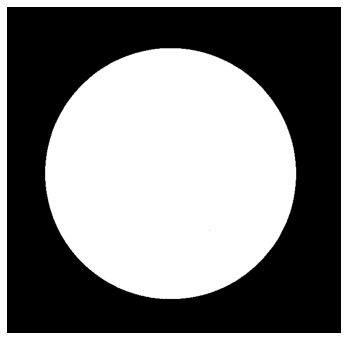

In [ ]:
val, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
print(val)
mostrar(thresh)

125.0


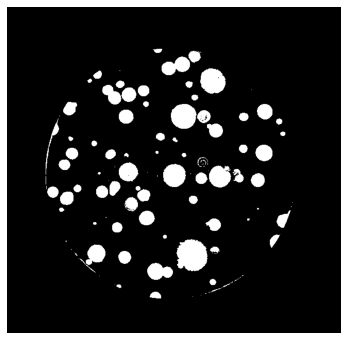

In [ ]:
val, thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY )
print(val)
mostrar(thresh)

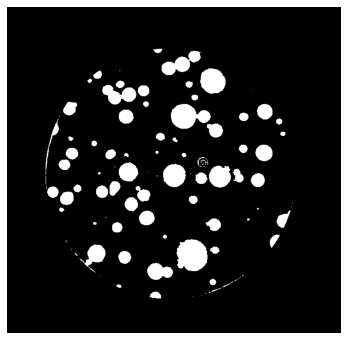

In [ ]:
#Aplicando operações morfológicas para preencher "burracos"
#Obtemos a imagem com correções conectadas.
#Segmentação com watershed devido as conexões
dilatacao = cv2.dilate(thresh, np.ones((3,3), np.uint8), iterations = 1)
seg = cv2.erode(dilatacao, np.ones((3,3), np.uint8), iterations = 1)
mostrar(seg)

In [ ]:
#possui operações com imagens
from scipy import ndimage as ndi
#Os maiores valores de pico da imagem
from skimage.feature import peak_local_max
# Permite implementar a tecnica watershed
from skimage.segmentation import watershed

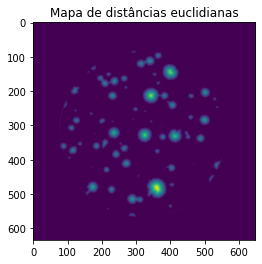

In [ ]:
#Transformada de distância euclidiana
#Converte uma imagem binária em uma imagem do tipo mapa de distância euclidiana
dist = ndi.distance_transform_edt(seg)
plt.title("Mapa de distâncias euclidianas")
plt.imshow(dist);

In [ ]:
#Variavel para armazenar informações dos picos
# 'True' matriz repressenta as coordenadas dos picos (valores de coordenadas)
# 'False retorna uma matriz booleana onde os picos são definidos como true
# min_distance: um pico precisa estar a pelo menos 20 pixel de distancia do outro
local_max = peak_local_max(dist,indices=False, min_distance= 15, labels= seg)
local_max, local_max.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """


(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]), (634, 648))

In [ ]:
#Aplicação da análise dos componentes conectados
markers = ndi.label(local_max, structure=np.ones((3,3)))[0]

In [ ]:
labels= watershed(dist, markers, mask=seg)

In [ ]:
#O valor negativo deve ser utilizado pois o algoritmo watershed
#considera assume que os marcadores assumem as areas locais minimas (vales no lugar de picos)
labels= watershed(-dist, markers, mask=seg)

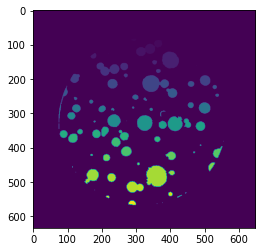

In [ ]:
plt.imshow(labels);

Segmentos únicos encontrados: 81


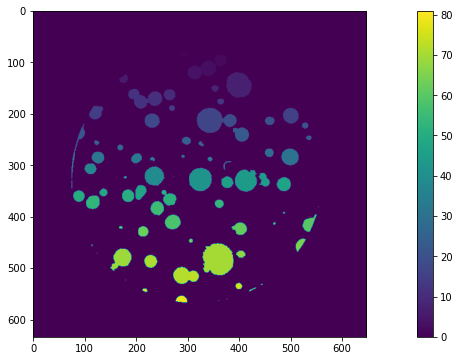

In [ ]:
#Vizualização de barra de cores
#Util para visualizar o alcançe das cores
fig= plt.gcf()
fig.set_size_inches(18,6)
plot=plt.imshow(labels)
print("Segmentos únicos encontrados: {}".format(len(np.unique(labels))-1))
plt.colorbar(plot);

# Nova abordagem através da detecção de contornos

125.0


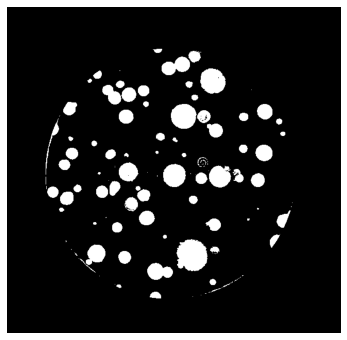

In [ ]:
val, thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY )
print(val)
mostrar(thresh)

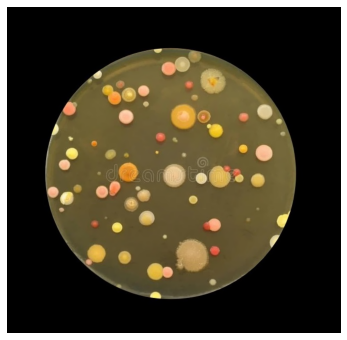

In [ ]:
# Não conseguimos resolver a imagem acima com operações morfológicas
# Filtro do open cv para redução de ruidos
#Também serve para manter as estruturas da imagem mais bem definidas

# sp= 20 e sr= 40 são parâmetros de certa forma padrão
#Alterar esses parâmetros pode distorcer a imagem
filtro= cv2.pyrMeanShiftFiltering(img, 1, 2)
mostrar(filtro)

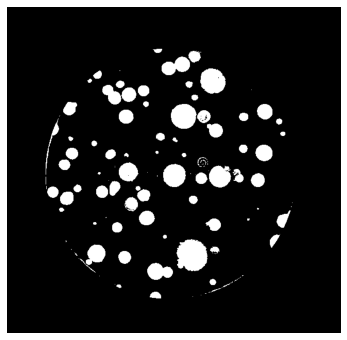

In [ ]:
gray= cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY)[1]
mostrar(thresh)

In [ ]:
def preenche_buracos(img_thresh, limiar = 1):
  # 1 Detectar os contornos
  # 2 Verificar quais contornos estão abaixo do limiar
  # 3 Adicionaremos os contornos abaixo do limiar em uma lista
  # 4 Prencher os contornos pequenos

  #retr_tree retorna todos os contornos
  # CHAIN_APPROX_SIMPLE retorna informações mais simples sobre os contornos
  contornos, _ = cv2.findContours(img_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  buracos = []
  for con in contornos:
    area = cv2.contourArea(con)
    if area < limiar:
      buracos.append(con)
  cv2.drawContours(img_thresh, buracos, -1, 255, -1)
  return img_thresh

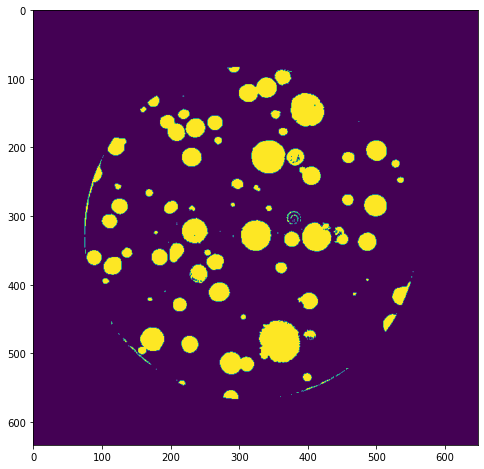

In [ ]:
seg = preenche_buracos(thresh)
fig= plt.gcf()
fig.set_size_inches(18,8)
plt.imshow(seg);

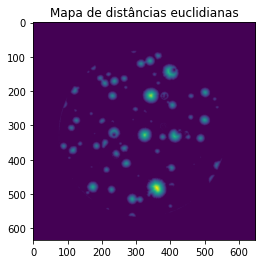

In [ ]:
#Transformada de distância euclidiana
#Converte uma imagem binária em uma imagem do tipo mapa de distância euclidiana
dist = ndi.distance_transform_edt(seg)
plt.title("Mapa de distâncias euclidianas")
plt.imshow(dist);

In [ ]:
#Variavel para armazenar informações dos picos
# 'True' matriz repressenta as coordenadas dos picos (valores de coordenadas)
# 'False retorna uma matriz booleana onde os picos são definidos como true
# min_distance: um pico precisa estar a pelo menos 20 pixel de distancia do outro
local_max = peak_local_max(dist,indices=False, min_distance= 15, labels= seg)
local_max, local_max.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  """


(array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]), (634, 648))

In [ ]:
#Aplicação da análise dos componentes conectados
markers = ndi.label(local_max, structure=np.ones((3,3)))[0]

In [ ]:
#O valor negativo deve ser utilizado pois o algoritmo watershed
#considera assume que os marcadores assumem as areas locais minimas (vales no lugar de picos)
labels = watershed(-dist, markers, mask=seg)

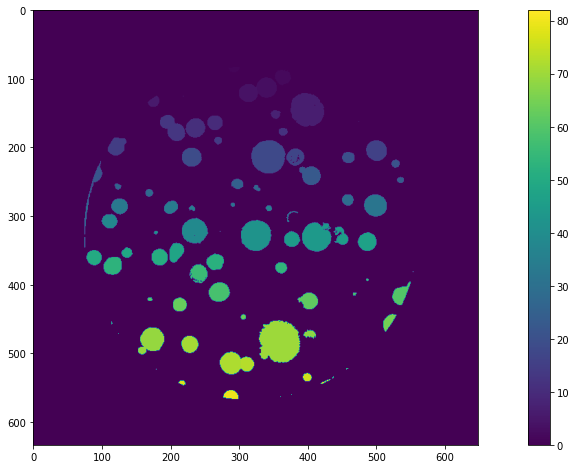

In [ ]:
#Vizualização de barra de cores
#Util para visualizar o alcançe das cores
fig= plt.gcf()
fig.set_size_inches(18,8)
plot=plt.imshow(labels)
plt.colorbar(plot);

Número de Colônias encontradas: 82


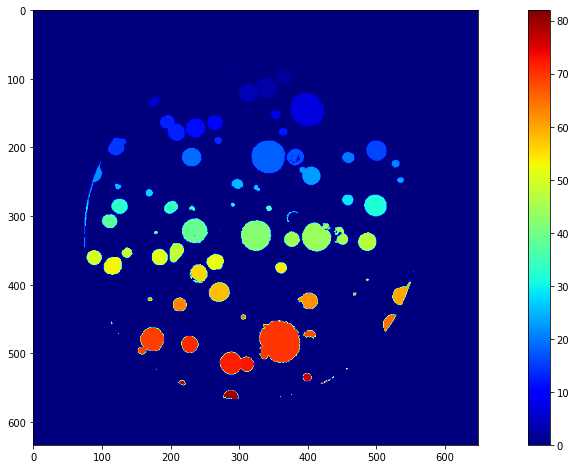

In [ ]:
#Vizualização de barra de cores
#Util para visualizar o alcançe das cores
fig= plt.gcf()
fig.set_size_inches(18,8)
plot=plt.imshow(labels, cmap='jet')
print("Número de Colônias encontradas: {}".format(len(np.unique(labels))-1))
plt.colorbar(plot);

In [ ]:
#Juntando todo o código em uma única função

def segmentacao_watershed(img, preenchimento = 10):
  #Carregamos a imagem
  original = gray = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  #Redução de ruídos
  filtro = cv2.pyrMeanShiftFiltering(img, 20, 40)
  #conversão para escala de cinza
  gray = cv2.cvtColor(filtro, cv2.COLOR_BGR2GRAY)
  #Aplicamos o threshold (limites da imagem)
  thresh = cv2.threshold(gray, 125, 255, cv2.THRESH_BINARY_INV )[1] #| cv2.THRESH_OTSU

  # Imagem complexa
  if preenchimento > 0:
    thresh = preenche_buracos(thresh, preenchimento)

  #implementação do watershed
  dist = ndi.distance_transform_edt(thresh)
  #Copia da função anterior
  dist_visual = dist.copy()
  local_max = peak_local_max(dist, indices=False, min_distance=15, labels=thresh)
  markers = ndi.label(local_max, structure=np.ones((3, 3)))[0]
  labels = watershed(dist, markers, mask=thresh)

  titulos = ['Imagem Original', 'Limiarização (objetos juntos)', 'Distance Transform', 'Watershed (objetos separados)']
  imagens = [original, thresh, dist_visual, labels]

  #Vizualização dos g´raficos
  fig = plt.gcf()
  fig.set_size_inches(16, 12)  
  for i in range(4):
      plt.subplot(2,2,i+1)
      # condição para colocar colormap jet apenas pra imagem com o resultado do watershed

      #Melhorar a visualização em mapa de cores
      #Imagem 3
      if (i == 3):
        cmap = "jet" 
      else:
        cmap = "gray"
      plt.imshow(imagens[i], cmap)
      plt.title(titulos[i]) 
      plt.xticks([]),plt.yticks([])     
  plt.show()
  return labels

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.


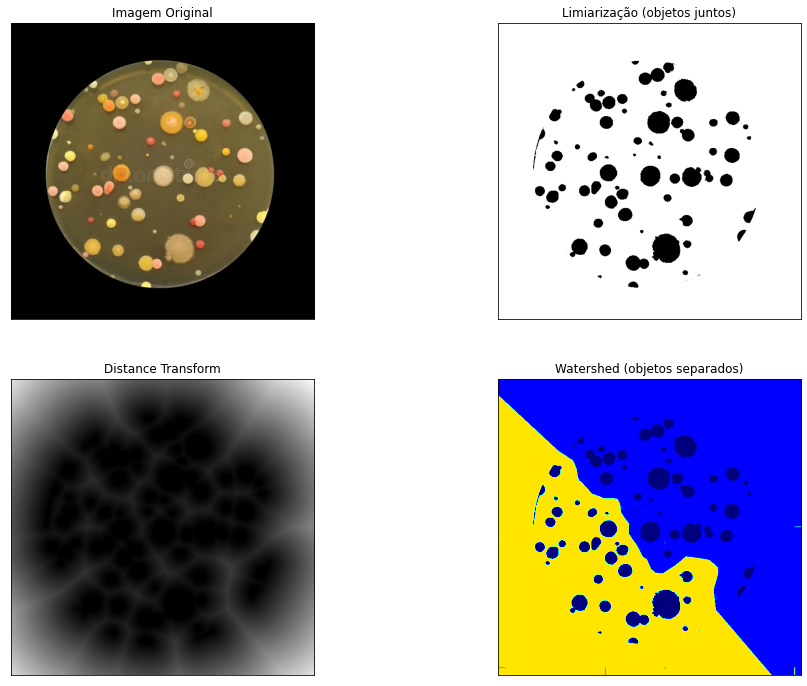

In [ ]:
img= cv2.imread('/content/gdrive/MyDrive/Segmentação_de_Imagens/imagens/COLONIA-2.jpg')
segmentação= segmentacao_watershed(img, 0)

# OUTRAS OPERAÇÕES (PÓS WATERSHED)

## Numeração dos Segmentos

In [ ]:
#mornalização da escala das cores da imagem entre 0 e 1
norm= plt.Normalize(vmin= labels.min(), vmax=labels.max())
seg_watershed= cmap(norm(labels))

In [ ]:
#Normalização dos pixel da imagem entre 0 e 255
seg_watershed=((seg_watershed*255).astype(np.uint8))
seg_watershed= cv2.cvtColor(seg_watershed, cv2.COLOR_RGB2BGR)

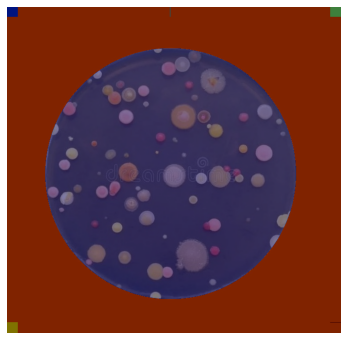

In [ ]:
img_sobreposição=cv2.addWeighted(seg_watershed, 0.5, img, 0.5, 0)
mostrar(img_sobreposição)

In [ ]:
#Salvar para uso posterior
#cv2.imwrite('segmentacao_watershed.jpg', seg_watershed)
#cv2.imwrite('segmentacao_sobreposicao.jpg', seg_sobreposicao)

## Numeração dos Segmentos

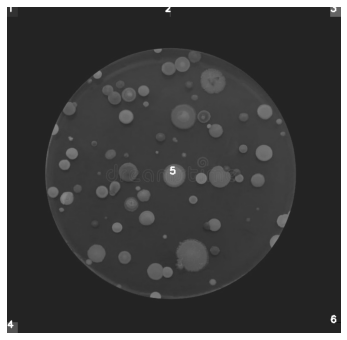

In [ ]:

img_final = img_sobreposição.copy()

for label in np.unique(labels):
  if label==0:
    continue
  mascara= np.zeros(gray.shape, dtype='uint8')
  mascara[labels==label]= 255
  cnts= cv2.findContours(mascara.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)[-2]
  c= max(cnts, key= cv2.contourArea)
  ((x,y), r)= cv2.minEnclosingCircle(c)
  cv2.putText(img_final, "{}".format(label), (int(x)-10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255, 200),2)

mostrar(img_final)